# Computation

If there any error occurs, please visit previous section to check all requirements [←](1_initialization.ipynb). Otherwise please submit an isuue.

## Initial settings

Prior starting the computation all the input conditions are set up.

1. TimePeriod : time span and granularity definition (around now)
2. Position : position of observer

As this code runs either way, it defines also functions, so the computation is more understandable

All of below printed can be preferably edited with an sqlite editor, otherwise please use attached python script (test.py)

In [8]:
%matplotlib inline
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from skyfield.api import load, Topos
from skyfield import timelib, almanac
plt.rcParams["figure.figsize"] = (16, 6) # (w, h)

################################
class Computation:
    def __init__(self):
        self.system = load('./source/de430.bsp')
        self.centerpoint = self.system['earth'] + Topos('50.1 N', '14.4 E')
        self.ts = load.timescale()
        self.observed = None
        self.o = {
            'moon': self.system['moon'],
            'mercury': self.system[1],
            'venus': self.system[2],
            'earth': self.system[2],
            'mars': self.system[4],
            'jupiter': self.system[5],
            'saturn': self.system[6],
            'uran': self.system[7],
            'neptun': self.system[8],
            'pluto': self.system[9]
        }

    def where_is(self, t):
        if self.observed:
            return self.centerpoint.at(self.format_time(t)).observe(self.observed)

    def degrees(self, t):
        # %t%: timestamp value
        return self.centerpoint.at(self.format_time(t)).observe(self.observed).radec()[1].degrees

    def distance(self, t):
        # %t%: timestamp value
        return self.centerpoint.at(self.format_time(t)).observe(self.observed).radec()[-1].au
    
    def moon_phase(self, t):
        # %t%: timestamp value
        return almanac.moon_phase(self.system, self.centerpoint.at(self.format_time(t)))
    
    def format_time(self, ts_object):
        if isinstance(ts_object, timelib.Time):
            return ts_object.utc_strftime('%Y-%m-%d %H:%M')
        elif isinstance(ts_object, pd.Timestamp):
            return self.ts.utc(ts_object.year, ts_object.month, ts_object.day, ts_object.hour, ts_object.minute)
        else:
            return


def frequency(day=0, hour=0, minute=0):
    if minute:
        return f'{minute}min'
    elif hour:
        return f'{60*hour}min'
    elif day:
        return f'{1440*day}min'  # 1 day timestep
    
    
def observer(start, end, gran):
    """iteration that computes values for given parameters
    %c%: center point position (with Topos module or another) 
    %start%: start date (pandas dataframe row)
    %end%: end date (pandas dataframe row)
    %gran%: granularity (pandas dataframe row)
    returns pandas dataframe
    """
    comp = Computation()
    print(
        f"""from {start.strftime('%d/%m/%Y')} to {end.strftime('%d/%m/%Y')} at time step {gran.total_seconds()/60} minutes""")
    time_span = pd.date_range(
        start, end, freq=f'{int(gran.total_seconds()/60)}min')
    obs = pd.DataFrame(time_span, columns=['date_time'])
    for obj in comp.o.keys():
        # print(dir(obj))
        comp.observed = comp.o[obj]
        obs[f'{obj}_dec'] = obs['date_time'].apply(comp.degrees)
        obs[f'{obj}_dist'] = obs['date_time'].apply(comp.distance)
        # if 'moon' in obj:  # moon phases are not valid for now
        #     obs['moon_phase'] = obs['date_time'].apply(comp.moon_phase)

    return obs
################################

now = datetime.now()


start_point = now.replace(day=1, hour=0, minute=0, second=0, microsecond=0)
end_point = start_point + relativedelta(months=1)
granularity = timedelta(hours=24)

print("Time settings verificaion:")
print(f"  Start: {start_point.strftime('%d/%m/%Y %H:%M:%S')}")
print(f"  Finish: {end_point.strftime('%d/%m/%Y %H:%M:%S')}")
print(f"  Time step: {granularity} hours")

Time settings verificaion:
  Start: 01/04/2023 00:00:00
  Finish: 01/05/2023 00:00:00
  Time step: 1 day, 0:00:00 hours


## Let's run



...

from 01/04/2023 to 01/05/2023 at time step 1440.0 minutes


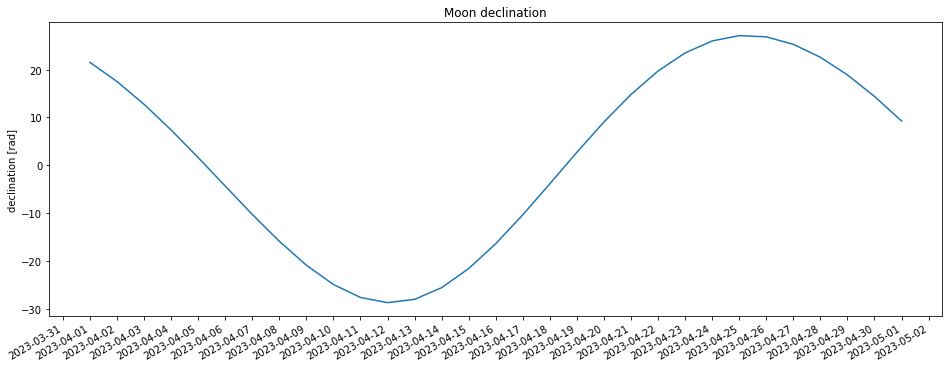

In [9]:
o = observer(start_point, end_point, granularity)
o.to_csv('./result/computed_current.csv', index=False, mode='w')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.title('Moon declination')
plt.ylabel('declination [rad]')
plt.plot(o['date_time'], o['moon_dec'])
plt.gcf().autofmt_xdate()
plt.show()

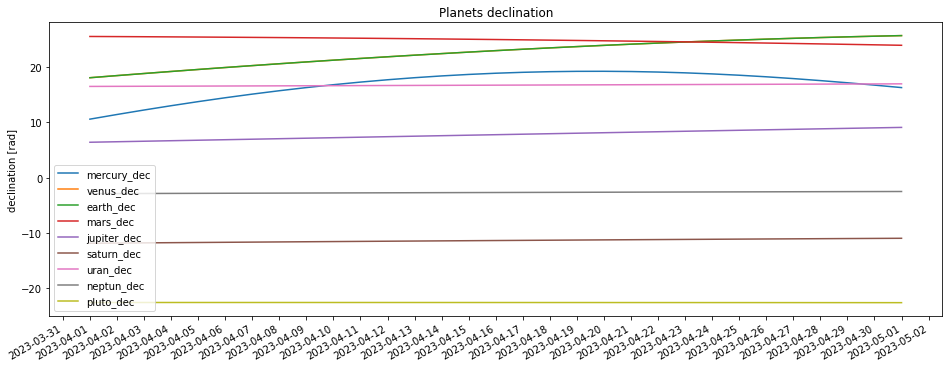

In [3]:
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.title('Planets declination')
plt.ylabel('declination [rad]')
series = []
for column in o:
    if '_dec' in column and 'moon' not in column:
        series.append(column)
        plt.plot(o['date_time'], o[column])
plt.gcf().autofmt_xdate()
plt.legend(series, loc='best')
plt.show()

## Further analysis

You can now continue to analysis part [→](3_analysis.ipynb).
